In [28]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [29]:
path = 'C:/Users/ralle/PycharmProjects/550-pattern_recognition/HW3/lfw/lfw'

In [30]:
transform = transforms.Compose([transforms.ToTensor()]) 
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [31]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


MPS device not found.


torch.Size([250, 250, 3])


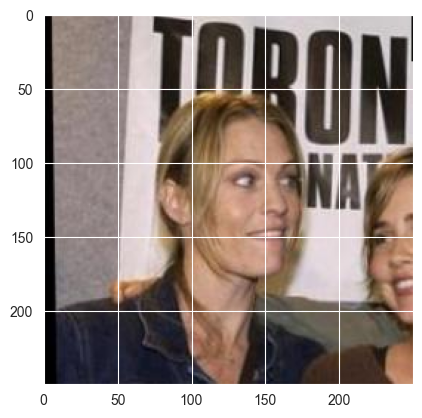

In [32]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function. 

# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [33]:
class VAE(nn.Module): #structure copied from my HW3, except for encode function
    
    def __init__(self):
        super(VAE,self).__init__()
        self.encoder = nn.Sequential( ## use conv layers to downscale the input
            nn.Conv2d(3, 32, 4, stride=2, padding=1), # b, 32, 125, 125
            nn.ReLU(True),
            nn.MaxPool2d(3, stride=2), # b, 32, 62, 62
            nn.Conv2d(32, 16, 2, stride=2, padding=1), # b, 16, 32, 32
            nn.ReLU(True),
            nn.MaxPool2d(5, stride=3) # b, 16, 10, 10
        )
        
        self.decoder = nn.Sequential( ## use convTranspose layers to upscale the input back to it original shape
            nn.ConvTranspose2d(8, 16, kernel_size=5, stride=2, padding=1), #input cut in half due to split
            nn.ReLU(),
            nn.ConvTranspose2d(16, 32, kernel_size=5, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 64, kernel_size=5, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=5, stride=2, padding=1), 
            nn.Upsample((250, 250), mode='bilinear', align_corners=False)    # Upsample to original size
        )  

    def encode(self,x): #uses code from VAE class tutorial
        param_f = self.encoder(x) ## get output from conv neural network
        mu_f, logvar_f = param_f.split(param_f.size(1)//2, 1)
        
        return mu_f, logvar_f ## return conv output, and mean + logvariance
        
    def decode(self,x):
        return self.decoder(x)

    def forward(self,x):
        mu, logvar = self.encode(x)
        
        std = torch.exp(0.5 * logvar) ## get standard dev
        z = torch.randn_like(mu) * std + mu ## get latent space value
        
        decoder_output = self.decoder(z)
        return decoder_output
    

## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly. 

In [34]:
model = VAE()

for x, _ in dataloader: ##only load x as y is not needed for a VAE
    print("Shape before: " + str(x.shape))
    
    mu, logvar = model.encode(x) ## get mean and log variance from encoder
    std = torch.exp(0.5 * logvar) ## find std dev
    z = torch.randn_like(mu) * std + mu ## get latent value
    # If we wanted to draw a different latent sample, just do the above line again as the torch.rand_like is used to generate a random sample from the gaussian probability distribution of the input.
    
    print("Shape of encoder output: " + str(z.shape))
    output = model.decode(z) ## generate new image, should not be anything good as this point however as model have not been trained
    print("Shape of decoder output: " + str(output.shape))   
    
    model_output = model.forward(x) ## check if forward pass is working
    
    assert model_output.shape == output.shape ## sanity check to see if shape of forward method is correct
    
    break

Shape before: torch.Size([32, 3, 250, 250])
Shape of encoder output: torch.Size([32, 8, 10, 10])
Shape of decoder output: torch.Size([32, 3, 250, 250])


##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


* create an optimizer for training

In [35]:
optim = torch.optim.Adam(model.parameters(), lr=0.001) ## This is not the best reason. But from my adv. AI class I learned that generally Adam optimizer is just better than other alternatives

In [36]:
loss_function = nn.MSELoss() ## I chose MSE as it is a good way of calculating the reconstruction loss. Whereas other loss functions such as categorical-cross-entropy would fit better for stuff like classification

##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [37]:
EPOCHS = 8

for epoch in range(EPOCHS):
    model.train()
    cumulated_loss = 0.0
    cumulated_kl_loss = 0.0
    
    for x, _ in dataloader:
        optim.zero_grad() ##Needed to reset gradients
        
        predicted_output = model(x)
        loss = loss_function(predicted_output, x)
        cumulated_loss += loss.data.item()
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
    # ===================log========================
    print(f'epoch [{epoch}/{EPOCHS}], MSE loss:{round(cumulated_loss / len(dataloader), 4)}')


epoch [0/8], MSE loss:0.0468
epoch [1/8], MSE loss:0.0272
epoch [2/8], MSE loss:0.0225
epoch [3/8], MSE loss:0.0203
epoch [4/8], MSE loss:0.0184
epoch [5/8], MSE loss:0.0173
epoch [6/8], MSE loss:0.0165
epoch [7/8], MSE loss:0.0159


##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


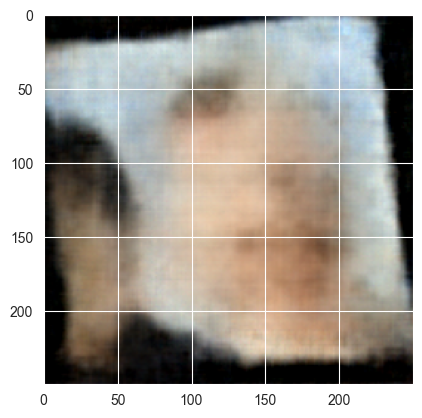

In [38]:
##Since the images are shuffled when creating the dataloader, ill take the first image from the dataset and plot it
random_image = None

for x,_ in dataloader:
    random_image = x
    break

predicted_image = model.forward(random_image)

image = predicted_image[0].permute(1, 2, 0)
plt.imshow(image.detach().numpy())

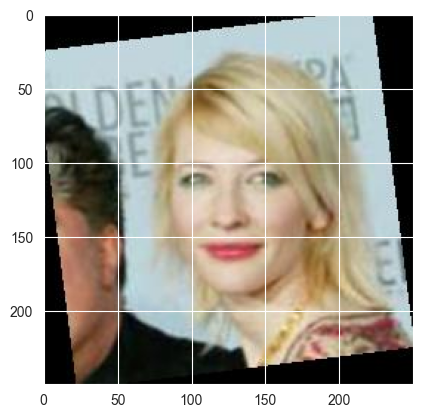

In [39]:
plt.imshow(random_image[0].permute(1, 2, 0))